# Прогнозирование оттока клиентов в фитнес-центре

Требуется научиться прогнозировать вероятность оттока для каждого из клиентов по историческим данным. Также требуется сформулировать рекомендации по повышению качества работы с клиентами.

### Данные

Данные о факте оттока в текущем месяце;

Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

### План проекта:  
[Шаг 1. Загрузка данных и подготовка к анализу](#step1)  
[Шаг 2. Исследовательский анализ данных](#step2)  
[Шаг 3. Построение модели прогнозирования оттока пользователей](#step3)  
[Шаг 4. Кластеризация пользователей](#step4)  
[Шаг 5. Выводы и рекомендации](#step5)  

### <a id="step1"> Шаг 1. Загрузка данных и подготовка к анализу</a>

Напишем функцию для пути файла, чтобы файл открывался и на локальном компьютере, и в практикуме

In [216]:
import os
def try_path(path):
    if os.path.exists(path):
        return path
    else:
        return "." + path

Подключим библиотеки, которые нам потребуются в дальнейшем

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Создадим dataframe c информаций об оттоке пользователей. Посмотрим 5 случайных записей из него

In [218]:
df = pd.read_csv(try_path('/datasets/gym_churn.csv'))
df.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1678,1,1,0,1,1,6,1,26,231.394863,4.0,1,2.640723,2.641722,0
1821,0,1,0,0,1,1,0,25,237.222488,1.0,0,1.805476,1.098346,1
2054,0,0,0,0,1,1,0,29,11.573675,1.0,1,1.552555,0.831657,1
1865,1,1,0,0,1,1,1,33,23.100524,1.0,4,1.228627,1.101623,0
771,1,1,1,0,1,12,1,31,63.486831,12.0,2,2.756225,2.807976,0


Приведем названия колонок в нижнему регистру

In [219]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Посмотрим информацию о таблице

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Посмотрим размер таблицы

In [221]:
df.shape

(4000, 14)

### Вывод

У нас есть информация о 4000 пользователях. В таблице содержится информация по 14 количественным признакам.

### <a id="step2"> Шаг 2. Исследовательский анализ данных</a>

- Изучите пропуски, средние значения и стандартного отклонения для признаков

Посмотрим есть ли в датасете пропущенные значения

In [222]:
df.isnull().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропущенных значений нет

Посмотрим описательные статистики

In [223]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [224]:
df.query('churn == 1')['lifetime'].describe()

count    1061.000000
mean        0.990575
std         1.110799
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: lifetime, dtype: float64

- Пол клиентов распределен практически поровну
- 84% пользователей проживают/работают в том же районе, где находится фитнес-центр
- Чуть меньше половины пользователей (48%) сотрудники компании-партнёра клуба
- 31% пользователей записались первый раз в клуб по промоакции "приведи друга"
- У 90% пользователей указан телефон в профиле
- В среднем длительность текущего действующего абонемента составляет 4.7 месяцев. Стандартное отклонение очень велико - 4.6 месяца. Не можем использовать среднее значение как меру центральной тенденции. У 50% пользователей длительность вбонемента составляет один месяц. Максмальная длительность текущего абонемента - год
- 41% пользователей посещали групповые занятия
- Средний возраст клиентов 29 лет. Стандартное оклонение небольшое - 3 года. Минимальный возраст - 18, максимальный - 41
- В среднем выручка от дополнительных услуг составляет 147 у.е. .Стандартное отклонение велико и составлеят 96 у.е.. Минимальное значение 0.14, максимальное - 552.5
- В среднем срок до окончания текущего абонемента составляет 4.3 месяца. Но стандартное отклонение очень велико - 4.1 месяца. Мнимальное значение - 1 месяц, максимальное - год
- В среднем время с первого обращения в клуб составляет 3.7 месяцев. И такое же стандартное отклонение 3.7 месяцев, что означает, что у нас есть много клиентов, которые пришли недавно в клуб, так и тех, кто давно занимается. Минимальное время с первого обращения - месяц, максимальное - 31 месяц
- Средняя частота среднего количества посещений в неделю - 1.8 занятий. Стандартное отклонение 0.9. Есть те, кто и вовсе не посещает занятий, так и те, кто посещает по 5 и более занятий в неделю. Минимальное значение - 0, максимаьное - 6
- Средняя частота среднего количества посещений в неделю в текущем месяце - 1.7, стандартное отклонение 1. Минимальное значение 0, максимальное - 6
- 26% пользователей закрыли свой абонемент

- Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 

In [225]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Пользователи, которые не закрыли абонемент, чаще  чем те, которые закрыли абонемент:
- живут или работают рядом с фитнес-центром
- являются сотрудниками компании-партнера клуба
- записались в перый раз по промоакции "приведи друга"
- посещают групповые занятия
- старше
- больше тратят на дополнительные услуги
- дольше занимаются в клубе
- больше посещают занятий в неделю
- больше посетили занятий в этом месяце
- обладают более длинными абонементами
- обладают абонементом, который закончится не скоро

- Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

C:\Users\nikotyan\PycharmProjects\yandex_project_2_property\venv\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\nikotyan\PycharmProjects\yandex_project_2_property\venv\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


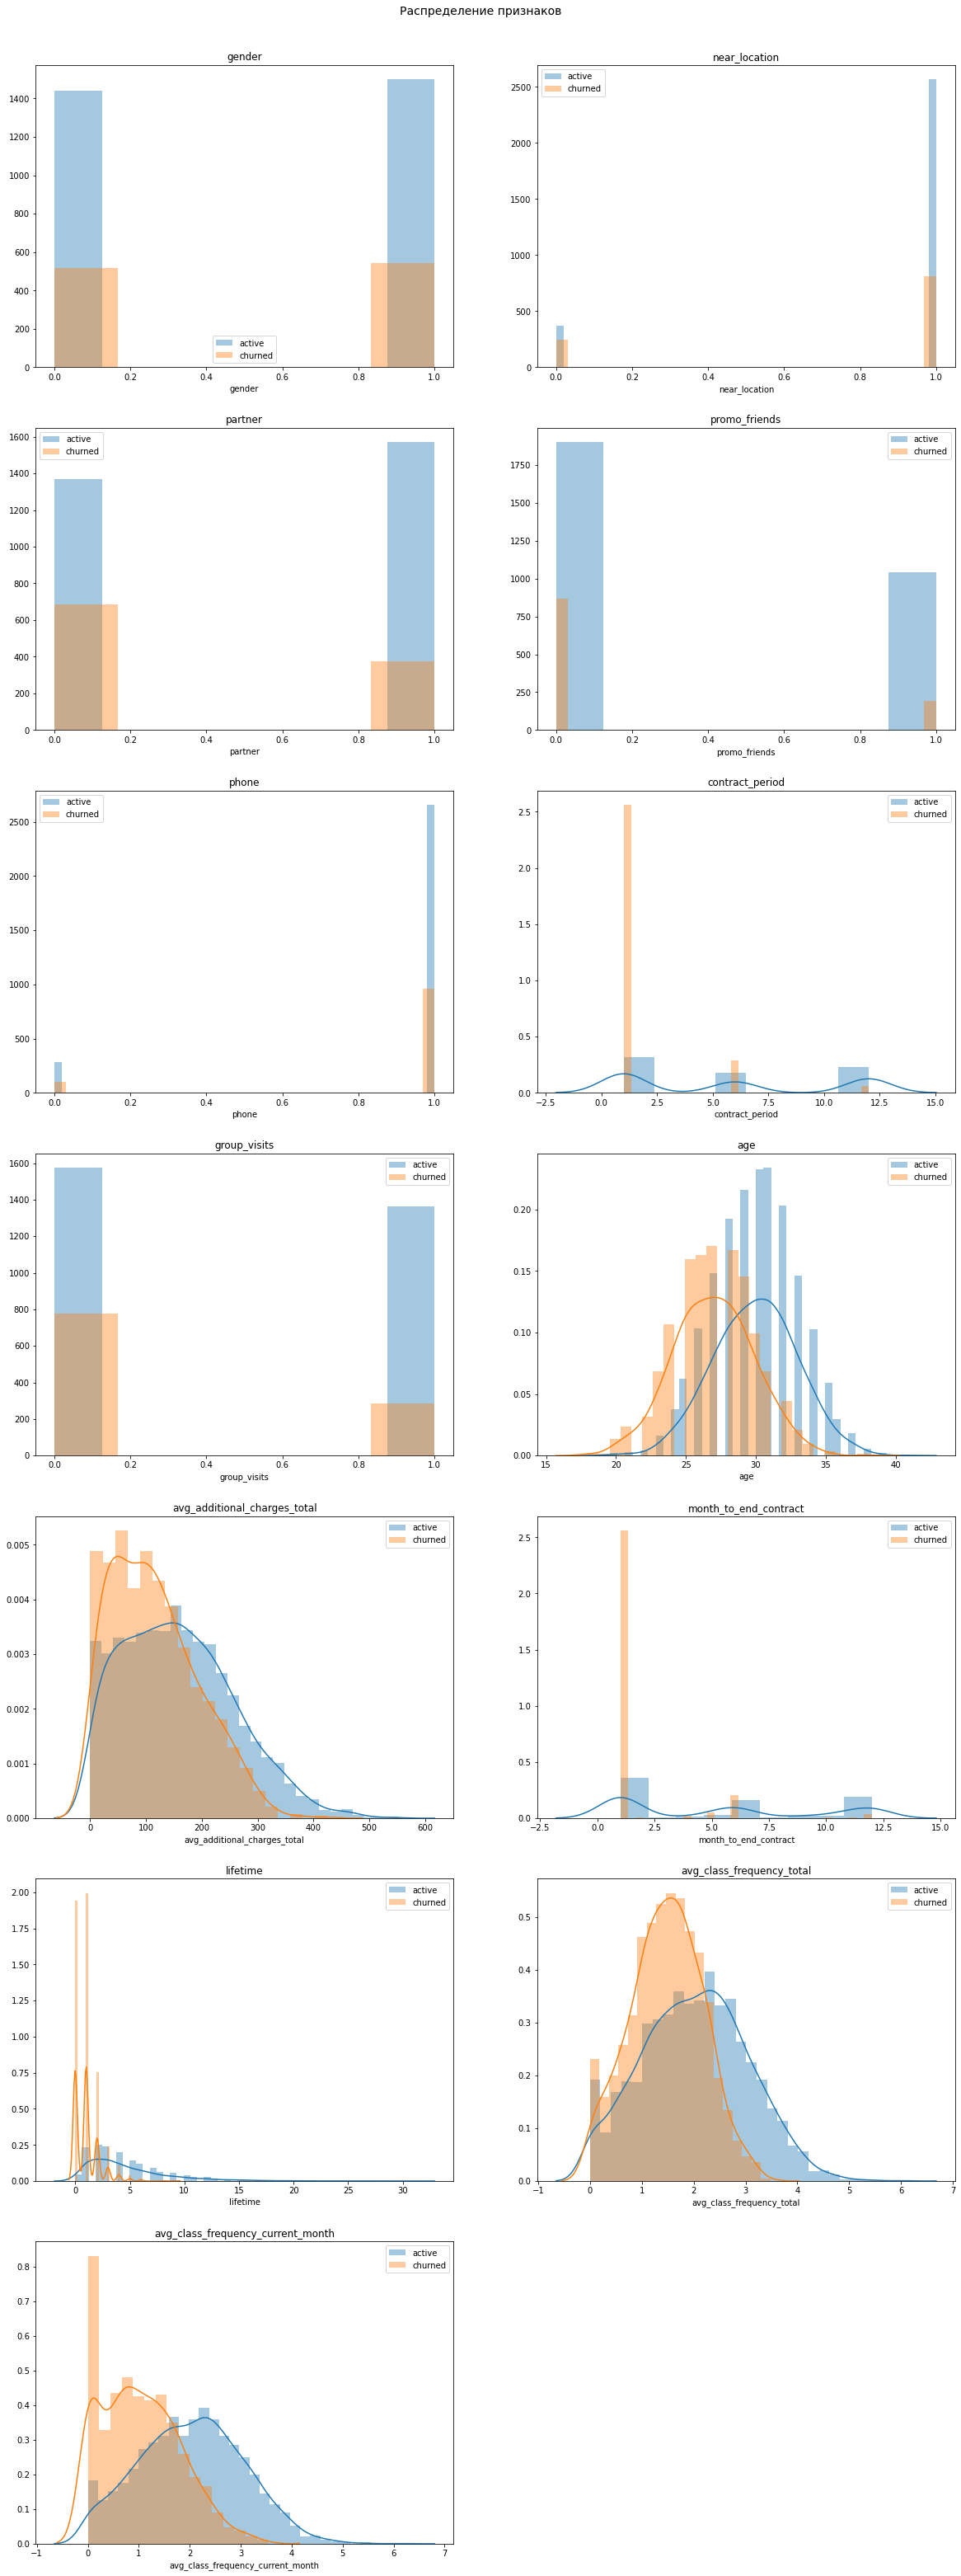

In [226]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,50))
i = 0
j = 0
plt.suptitle('Распределение признаков', fontsize = 14);
for col in df.drop('churn', axis = 1):
    if df[col].max() == 1:
        kde_val = False
    else:
        kde_val = True
    sns.distplot(df.query('churn == 0')[col],ax = axes[i,j], label = 'active', kde = kde_val); 
    sns.distplot(df.query('churn == 1')[col], ax = axes[i,j], label = 'churned', kde = kde_val);
    axes[i,j].legend();
    axes[i,j].set_title(col); 
    
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1
fig.subplots_adjust(top=0.96)
fig.delaxes(axes[6][1])


- Большая часть пользователей, которые больше не ходят в спортзал, занимались менее 2,5 месяцев
- У большей части пользователей, которые больше не ходят в спортзал, до окончания аобнемента осталось менее 2.5 месяцев
- У большей части пользователей, которые больше не ходят в спортзал, прошло менее 2 месяецв с момента первого обращения в фитнес-центр.То есть клиенты решают больше не ходить в зал в основном в первые месяцы посещения.


- Постройте матрицу корреляций и отобразите её.

Построим матрицу корреляции

In [227]:
cor_matrix = df.corr()
cor_matrix

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


Построим heatmap по матрице корреляции

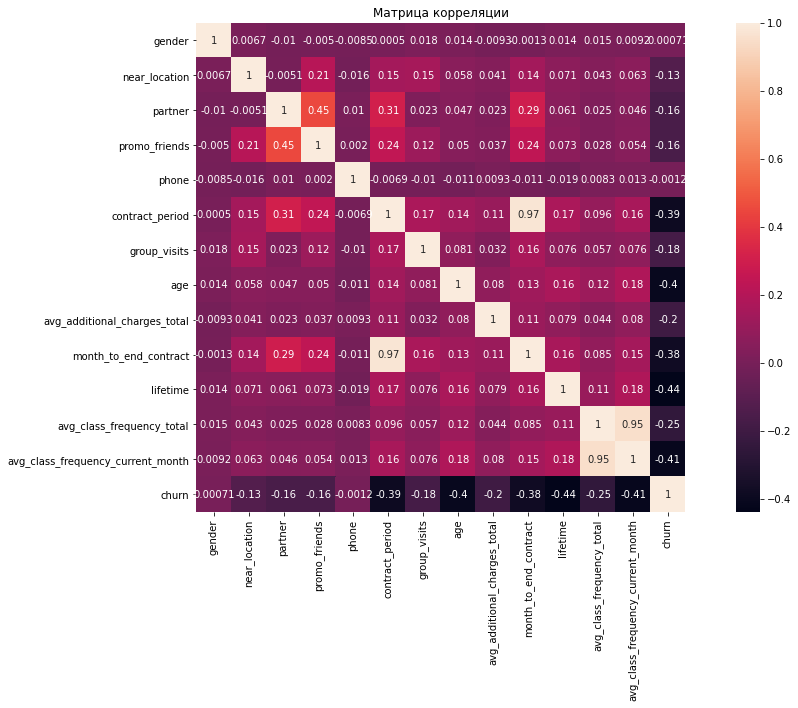

In [228]:
plt.figure(figsize=(18, 9))
plt.title('Матрица корреляции')
sns.heatmap(cor_matrix, annot = True, square=True);

Высокий коэффициент корреляции у признаков: 
- avg_class_frequency_total и avg_class_frequency_current_month. Чем меньше в среднем человек посетил занятий, тем скорее всего меньше он их посетил за все время абонемента
- contract_period и month_to_end_contract. Чем меньше период аобнемента, тем скорее всего меньше осталось месяцев до его окончания

Для того чтобы нам в дальнейшем верно построить модель нам надо избавиться от высококоррелирующих признаков. Оставим один из каждой пары

In [229]:
df_for_model = df.drop(['avg_class_frequency_current_month','month_to_end_contract'], axis=1)
df_for_model.shape

(4000, 12)

### Вывод

В ходе EDA выяснили:
- Пол клиентов распределен практически поровну
- Большинство пользователей проживают/работают в том же районе, где находится фитнес-центр
- Примерно половина пользователей сотрудники компании-партнёра клуба
- Треть пользователей записались первый раз в клуб по промоакции "приведи друга"
- У большинства пользователей указан телефон в профиле
- Длительность абонемента колеблется от месяца до года
- Чуть меньше половины клиентов пользователей посещали групповые занятия
- Средний возраст клиентов 29 лет. Минимальный возраст - 18, максимальный - 41
- Минимальное значение средней выручки 0.14, максимальное - 552.5
-  Мнимальное значение срока до окончания текущего абонемента- 1 месяц, максимальное - год
- Минимальное время с первого обращения в клуб - месяц, максимальное - 31 месяц
-  Есть те, кто и вовсе не посещает занятий, так и те, кто посещает по 5 и более занятий в неделю.
- Средняя частота среднего количества посещений в неделю в текущем месяце - 1.7, стандартное отклонение 1. Минимальное значение 0, максимальное - 6
- 26% пользователей закрыли свой абонемент

Пользователи, которые не закрыли абонемент, чаще  чем те, которые закрыли абонемент:
- живут или работают рядом с фитнес-центром
- являются сотрудниками компании-партнера клуба
- записались в перый раз по промоакции "приведи друга"
- посещают групповые занятия
- старше
- больше тратят на дополнительные услуги
- дольше занимаются в клубе
- больше посещают занятий в неделю
- больше посетили занятий в этом месяце
- обладают более длинными абонементами
- обладают абонементом, который закончится не скоро

- Большая часть пользователей, которые больше не ходят в спортзал, занимались менее 2,5 месяцев
- У большей части пользователей, которые больше не ходят в спортзал, до окончания аобнемента осталось менее 2.5 месяцев
- У большей части пользователей, которые больше не ходят в спортзал, прошло менее 2 месяецв с момента первого обращения в фитнес-центр.То есть клиенты решают больше не ходить в зал в основном в первые месяцы посещения.

Выявили высокий коэффициент корреляции у признаков: 
- avg_class_frequency_total и avg_class_frequency_current_month.
- contract_period и month_to_end_contract.

Для того чтобы нам в дальнейшем верно построить модель избавились от высококоррелирующих признаков avg_class_frequency_current_month,month_to_end_contract

### <a id="step3"> Шаг 3. Построение модели прогнозирования оттока пользователей</a>

Постройте модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце

- Разбейте данные на обучающую и валидационную выборку функцией train_test_split().

In [230]:
X = df_for_model.drop('churn', axis=1)
y = df_for_model['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Стандартизируем признаки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Создадим функцию для вывода метрик

In [231]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))


- Обучение модели логистической регрессией

In [232]:
model_lr_reg = LogisticRegression(random_state=0) 
# обучите модель
model_lr_reg.fit(X_train_st, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
lr_predictions = model_lr_reg.predict(X_test_st)
lr_probabilities = model_lr_reg.predict_proba(X_test_st)[:,1] 
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81


- Обучение модели случайным лесом

In [233]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 9)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]# Ваш код здесь
# выведем все метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.80
	Recall: 0.77


Посмотрим какие признаки больше всего влияют на целевую переменную ждя линейной регресии

In [234]:
importance = model_lr_reg.coef_[0]
importance_df = pd.DataFrame({'feauters': X.columns, 'importance':abs(importance)})
importance_df.sort_values(by = 'importance', ascending = False)

,feauters,importance
9,lifetime,3.879688
5,contract_period,1.316552
7,age,1.093218
10,avg_class_frequency_total,0.730469
8,avg_additional_charges_total,0.567072
6,group_visits,0.359770
3,promo_friends,0.217953
4,phone,0.120001
1,near_location,0.088120
2,partner,0.053055


### Вывод

- Доля правильных ответов выше у логистической регрессии, но для нас это не лучшая оценка успешности модели, т.к. у нас не сбалансированы классы (26% пользователей закрыли абонемент, 74% - не закрыли) и модель может просто в большинстве случаев,  не опираясь на реальные данные, показывать незакрытие и угадать
- Precision (TP/TP+FP) чуть выше у случайного леса, recall(TP/TP+FN) чуть выше у логистической регрессии. В нашем случае случайное отнесение клиента к классу "собирается закрыть абонемент" менее критичен чем не нахождение клиента, который хочет уйти. Поэтому нам нужно выбрать модель с более высокой метрикой recall. Считаем более успешной модель логистической регрессии

- Боле всего на целевую переменную влияют время с первого обращения в клуб, срок абонемента и возраст

### <a id="step4"> Шаг 4. Кластеризация пользователей</a>

- Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму.  На основании полученного графика предположите, какое количество кластеров можно выделить.

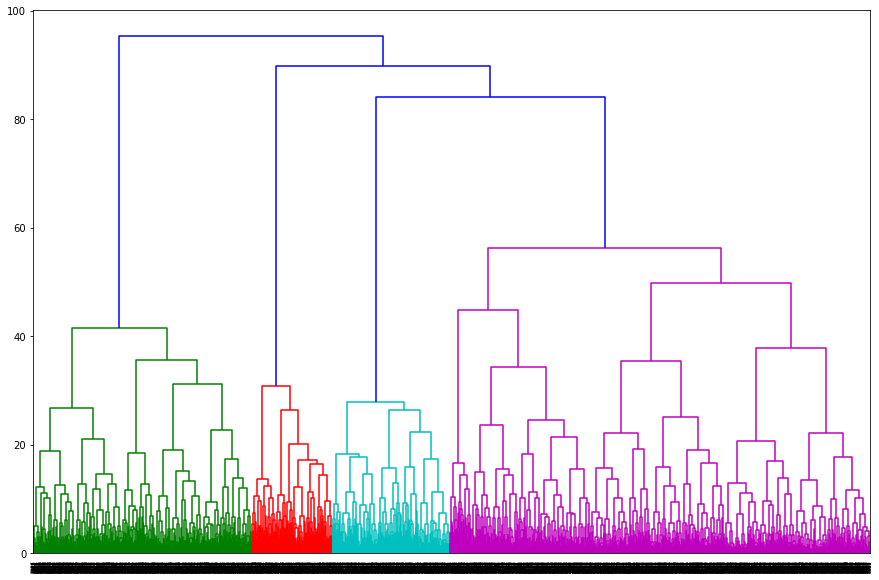

In [235]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

На основании дендрограммы можем выделить четыре кластера

- Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. 

In [236]:
km = KMeans(n_clusters = 5) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 
df['labels'] = labels
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,labels
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,2
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,4
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,1
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,1


- Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [237]:
df.groupby('labels').mean().T

labels,0,1,2,3,4
gender,0.500898,0.497992,0.523316,0.508772,0.526620
near_location,0.000000,0.994980,0.862694,1.000000,0.995370
partner,0.488330,0.893574,0.471503,0.187135,0.438657
promo_friends,0.077199,1.000000,0.305699,0.055973,0.011574
phone,1.000000,1.000000,0.000000,1.000000,1.000000
contract_period,2.978456,6.863454,4.777202,1.951546,7.002315
group_visits,0.231598,0.520080,0.427461,0.315789,0.531250
age,28.685817,29.534137,29.297927,27.952381,30.758102
avg_additional_charges_total,137.277472,152.377724,144.208179,124.452646,179.292792
month_to_end_contract,2.804309,6.282129,4.466321,1.889724,6.349537


 - В 0 группе характерны клиенты, у которых фитнес рядом с работой/домом,  оставили номер телефоа
 - В 1 группе характерны клиенты, которые  пришли не по промо "приведи друга", фитнес находится рядом с работой/домом, с недлинным абонементом
 - Во 2 группе характерны клиенты, которые  пришли по промо "приведи друга", фитнес находится рядом с работой/домом,
 - В 3 группе характерны клиенты, которые не живут и не работают рядом с фитнес-центром
 - В 4 группе характерны клиенты, которые пришли не по промо "приведи друга", потратии больше всех в среднем на доп услуги, давно занимаются в клубе

- Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

C:\Users\nikotyan\PycharmProjects\yandex_project_2_property\venv\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\nikotyan\PycharmProjects\yandex_project_2_property\venv\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


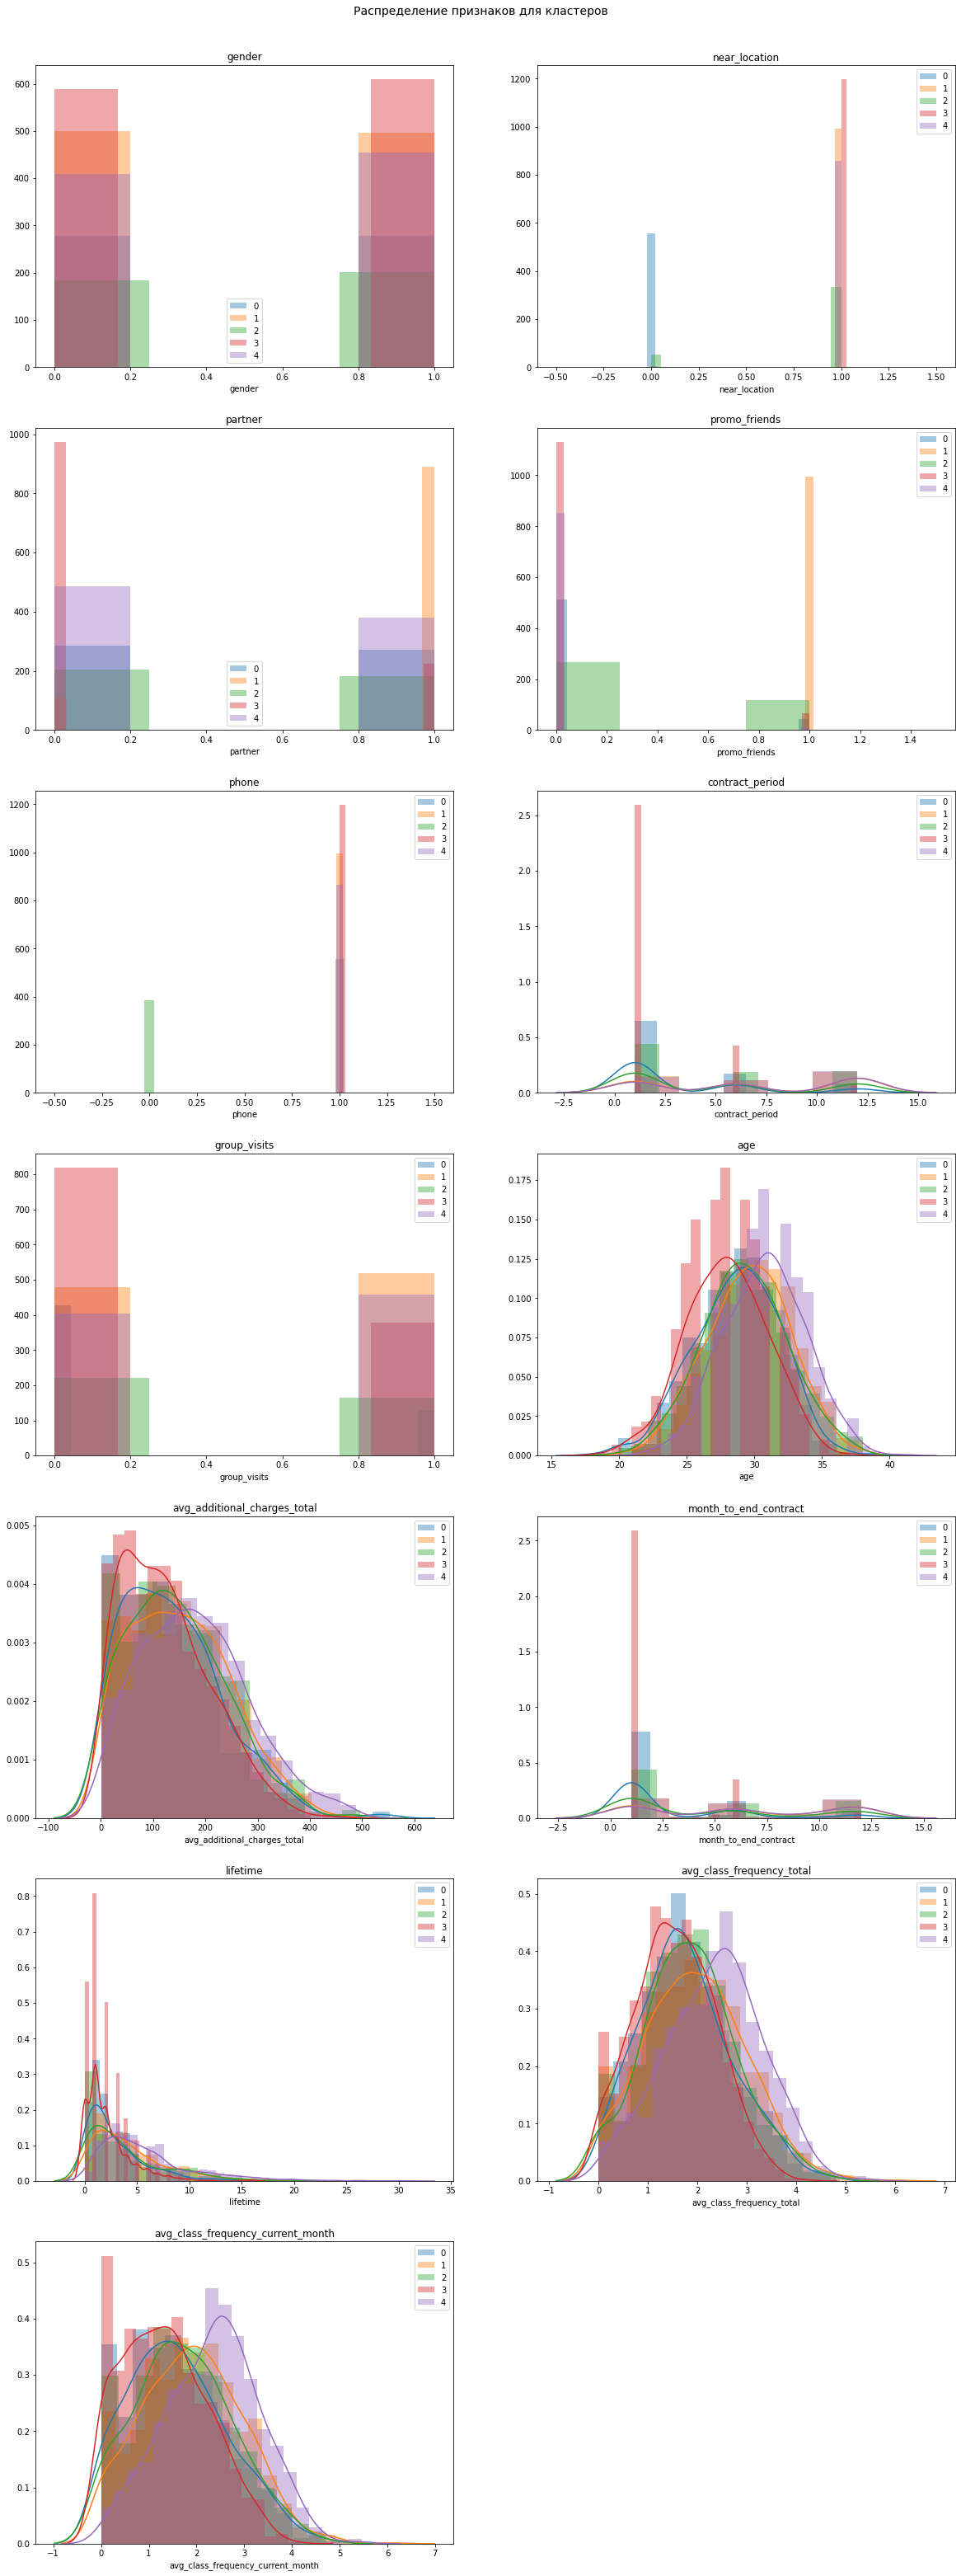

In [238]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,50))
i = 0
j = 0
labels = df['labels'].sort_values().unique()
plt.suptitle('Распределение признаков для кластеров', fontsize = 14);
for col in df.drop(['churn','labels'], axis = 1):
    if df[col].max() == 1:
        kde_val = False
    else:
        kde_val = True
    for label in labels: 
        sns.distplot(df.query('labels == @label')[col],ax = axes[i,j], label = label, kde = kde_val); 
    axes[i,j].legend();
    axes[i,j].set_title(col); 
    
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1
fig.subplots_adjust(top=0.96)
fig.delaxes(axes[6][1])

- В основном пользователи, у которых фитнес не  рядом с домом/офисом, относятся к 3 группе. Больше всего пользователей, у которых фитнес рядом с домом/работой в 1 группе
- В основном пользователи, которые являются сотрудниками компании-партнёра клуба относятся ко 2 группе. Те, которые не являются - к 1
- В основном пользователи, которые пришли по промо "привели друга" относятся ко 2 группе. Те, которые пришли не по промо - к 1
- Не оставившие телефон пользователи относятся к группе 0
- Больше всего клиентов с коротким абонементом в группе 1. Самые длинные абонементы у групп 4 и 2
- Больше всего пользователей из группы 1 посещали групповые тренировки, меньше всего - из группы 2
- Моложе всех в среднем клиенты группы 1, старше - 4
- Самые большие дополнительные траты делали клиенты группы 1
- У клиентов группы 1 быстрее всех скоро закончится абонемент, у 2 и 4 - медленнее всех
- В 1 группы много клиентов, которые ходят в зал меньше пяти лет
- Клиенты 4 группы в среднем посещают больше всего занятий в неделю, 1 - меньше
- Клиенты 4 группы в среднем в этом месяце посетили больше всего занятий в неделю, 3 - меньше

- Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [239]:
churn_ratio_by_clusters = df.groupby('labels').agg({'churn':['count','sum']}).reset_index()
churn_ratio_by_clusters.columns = ['cluster','qty','churned']
churn_ratio_by_clusters['churn_ratio'] = round((churn_ratio_by_clusters['churned'] / churn_ratio_by_clusters['qty']) * 100,2)
churn_ratio_by_clusters.sort_values(by = 'churn_ratio')

,cluster,qty,churned,churn_ratio
4,4,864,11,1.27
1,1,996,131,13.15
2,2,386,103,26.68
0,0,557,224,40.22
3,3,1197,592,49.46


### Вывод

Более всего склонны к оттоку клиенты групп:
    - 1. Фитнес рядом с работой/домом. Не сотрудники компании-партнёра клуба. Пришли не по промо. Короткий абонемент. Посешают групповые тренировки. Моложе всех. Самые большие доп траты. Меньше всего занятий в неделю посещают 
    - 3. Фитнес не рядом с работой/домом. Меньше всего занятий в неделю посетили в этом месяце
Менее всего склоны к отттоку кленты групп:
    - 4. Длинный абонемент. Старше всех. Больше всего занятий в неделю посещают
    - 2. Сотрудники компании-партнёра клуба. Пришли по промо. Длинный абонемент. В основном не посещают групповые тренировки.

### <a id="step5"> Шаг 5. Выводы и рекомендации</a>

- Люди,которые не посещают групповые тренировки, с более высокой вероятностью остаются в клубе. Они же приходят по промо и являются сотрудниками компании-партнера. Скорее всего эти люди посещают индивидуальные тренировки или сами занимаются в тренажерном зале. Можно попробовать при первом обращении в клуб давать бесплатное пробное занятие с тренером и скидку на первый абонемент занятий с тренером для нового клиента и того, кто привел его. Индивидуальные тренировки дают большое вовлечение клиента, более быстрый результат и с меньшей вероятностью клиент захочет уйти. В рекламе для сотрудников компаний-партнеров стоит особо обращать внимание на акцию "приведи друга" и индивидуальные тренировки.
- С большей вероятностью остаются клиенты сотрудники компании-партнёра клуба. Нужно расширять сеть компаний-партнёров.
- С большой вероятностью остаются клиенты более старшего возраста с длинным абонементом и посещаюшие большое количество занятий. Имеет смысл таргетировать рекламу на людей более старшего возраста и предлагать скидку на длинный абонемент. 
- Плохо посещают занятия люди, которые не работают и не живут рядом с залом. То есть те люди, которые живут/работают рядом с большей веротяностью останутся. Нужно включать в сеть клиентов-партнеров компании чьи офисы располагаются рядом, больше рекламировать клуб в пределах района. Например, положить листовки о клубе в ближафшие кафе.